# Multi-Linear Regression

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# statsmodels for detailed OLS summary and VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn for models, preprocessing and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load dataset

In [123]:
df = pd.read_csv("ToyotaCorolla - MLR.csv", encoding='latin1')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1436, 11)


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [124]:
# Shape of data
data.shape

(1436, 9)

## Inspect & rename columns

In [125]:
# Print columns and basic info to detect typical names and dtypes
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

# Some datasets use slightly different names; map common names to friendly ones
rename_map = {}
for c in df.columns:
    low = c.lower()
    if 'age' in low and 'age' not in rename_map:
        rename_map[c] = 'Age'
    if low.startswith('km') and 'KM' not in rename_map.values():
        rename_map[c] = 'KM'
    if 'fuel' in low and 'fuel' not in rename_map.values():
        rename_map[c] = 'FuelType'
    if 'hp' in low and 'HP' not in rename_map.values():
        rename_map[c] = 'HP'
    if 'automatic' in low and 'Automatic' not in rename_map.values():
        rename_map[c] = 'Automatic'
    if low == 'cc' or ('cc' in low and 'CC' not in rename_map.values()):
        rename_map[c] = 'CC'
    if 'door' in low and 'Doors' not in rename_map.values():
        rename_map[c] = 'Doors'
    if 'weight' in low and 'Weight' not in rename_map.values():
        rename_map[c] = 'Weight'
    if 'price' in low and 'Price' not in rename_map.values():
        rename_map[c] = 'Price'

print("\nAuto-detected rename map (will rename if present):")
print(rename_map)

df = df.rename(columns=rename_map)
print("\nColumns after rename:", df.columns.tolist())


Columns: ['Price', 'Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Weight']

Dtypes:
 Price         int64
Age_08_04     int64
KM            int64
Fuel_Type    object
HP            int64
Automatic     int64
cc            int64
Doors         int64
Cylinders     int64
Gears         int64
Weight        int64
dtype: object

Auto-detected rename map (will rename if present):
{'Price': 'Price', 'Age_08_04': 'Age', 'KM': 'KM', 'Fuel_Type': 'FuelType', 'HP': 'HP', 'Automatic': 'Automatic', 'cc': 'CC', 'Doors': 'Doors', 'Weight': 'Weight'}

Columns after rename: ['Price', 'Age', 'KM', 'FuelType', 'HP', 'Automatic', 'CC', 'Doors', 'Cylinders', 'Gears', 'Weight']


## Keep only required columns

In [126]:
# Keep the columns required by your assignment if they exist in the dataset.
expected_cols = ['Price','Age','KM','FuelType','HP','Automatic','CC','Doors','Weight']
present = [c for c in expected_cols if c in df.columns]
print("Present columns used:", present)

# Create working dataframe with only present columns for robustness
data = df[present].copy()
print("Working data shape:", data.shape)
data.head()


Present columns used: ['Price', 'Age', 'KM', 'FuelType', 'HP', 'Automatic', 'CC', 'Doors', 'Weight']
Working data shape: (1436, 9)


,Price,Age,KM,FuelType,HP,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,0,2000,3,1165
1,13750,23,72937,Diesel,90,0,2000,3,1165
2,13950,24,41711,Diesel,90,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,2000,3,1170


## Cleaning & convert types

In [127]:
# Convert columns to numeric types if possible and inspect missing values.

# Convert Automatic to numeric if it's stored as string 'Yes'/'No'
if 'Automatic' in data.columns and data['Automatic'].dtype == object:
    data['Automatic'] = data['Automatic'].apply(lambda x: 1 if str(x).strip().lower() in ['yes','y','true','1'] else 0)

# Ensure Doors is numeric (sometimes stored as strings)
if 'Doors' in data.columns:
    data['Doors'] = pd.to_numeric(data['Doors'], errors='coerce')

# Print missing counts
print("Missing values per column:\n", data.isnull().sum())

# Drop rows with missing values (simple approach — for beginners)
rows_before = data.shape[0]
data = data.dropna().reset_index(drop=True)
print(f"Dropped {rows_before - data.shape[0]} rows with missing values. New shape: {data.shape}")


Missing values per column:
 Price        0
Age          0
KM           0
FuelType     0
HP           0
Automatic    0
CC           0
Doors        0
Weight       0
dtype: int64
Dropped 0 rows with missing values. New shape: (1436, 9)


## Exploratory Data Analysis (EDA)

In [128]:
print("\nNumeric summary:")
display(data.describe().round(2))


Numeric summary:


,Price,Age,KM,HP,Automatic,CC,Doors,Weight
count,1436.00,1436.00,1436.00,1436.00,1436.00,1436.00,1436.00,1436.00
mean,10730.82,55.95,68533.26,101.50,0.06,1576.86,4.03,1072.46
std,3626.96,18.60,37506.45,14.98,0.23,424.39,0.95,52.64
min,4350.00,1.00,1.00,69.00,0.00,1300.00,2.00,1000.00
25%,8450.00,44.00,43000.00,90.00,0.00,1400.00,3.00,1040.00
50%,9900.00,61.00,63389.50,110.00,0.00,1600.00,4.00,1070.00
75%,11950.00,70.00,87020.75,110.00,0.00,1600.00,5.00,1085.00
max,32500.00,80.00,243000.00,192.00,1.00,16000.00,5.00,1615.00


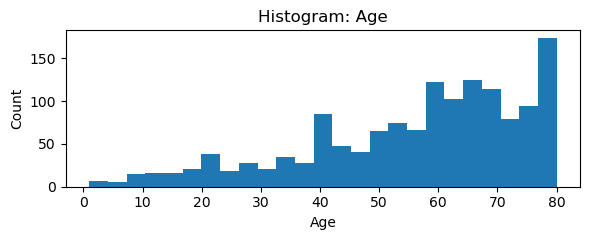

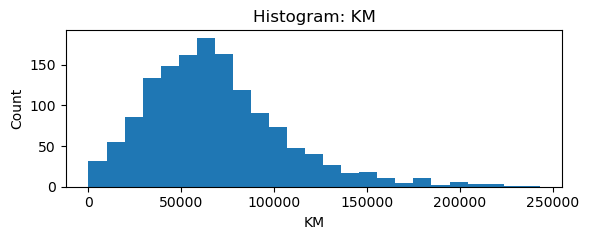

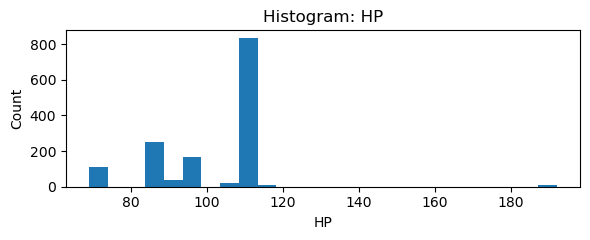

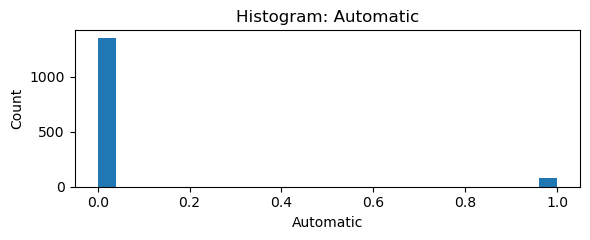

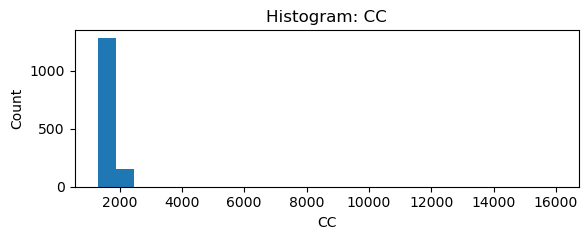

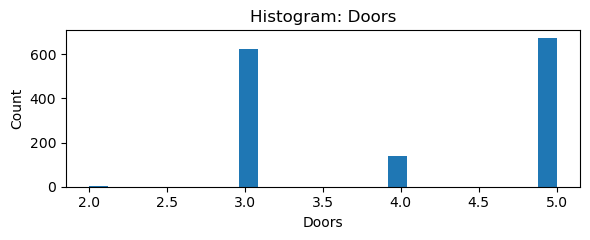

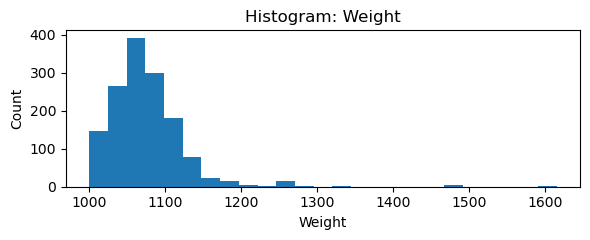

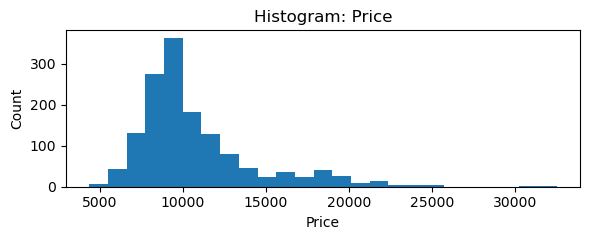

In [129]:
# Histograms for numeric columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Price')  # exclude target for predictor histograms

for col in num_cols + ['Price']:
    plt.figure(figsize=(6,2.5))
    plt.hist(data[col], bins=25)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

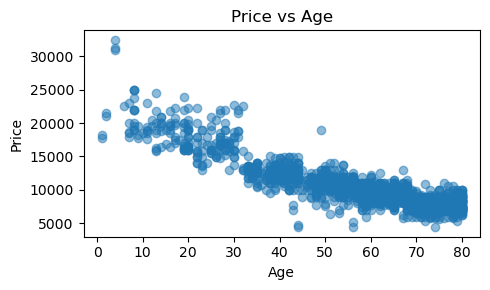

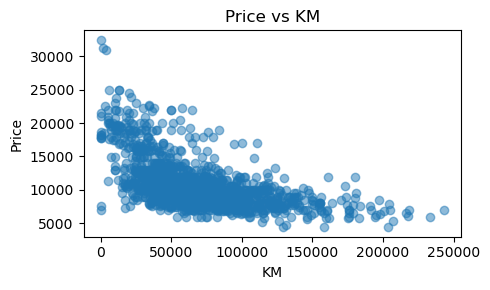

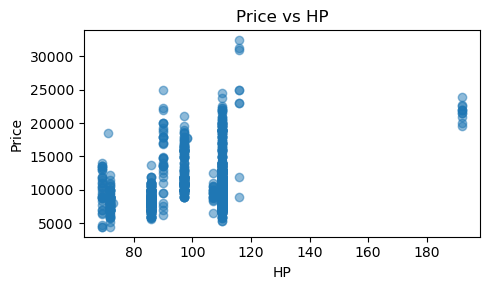

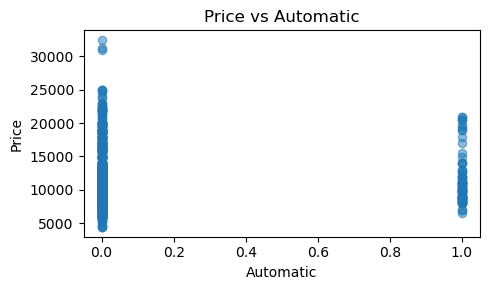

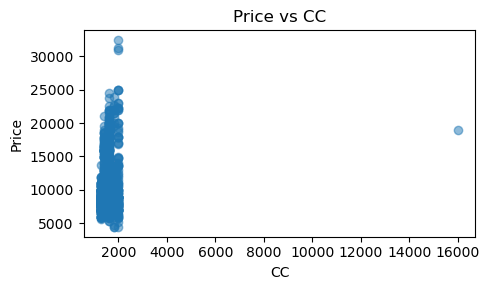

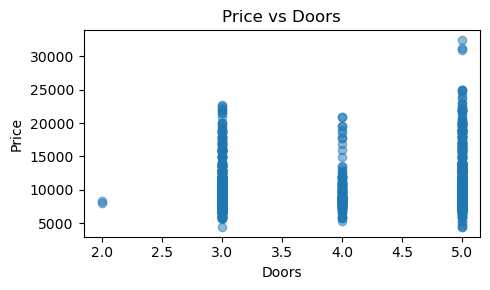

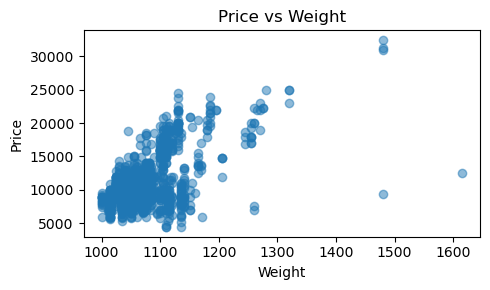

In [130]:
# Scatterplots: Price vs each numeric predictor
for col in num_cols:
    plt.figure(figsize=(5,3))
    plt.scatter(data[col], data['Price'], alpha=0.5)
    plt.title(f"Price vs {col}")
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()


Correlation matrix (numeric):


,Price,Age,KM,HP,Automatic,CC,Doors,Weight
Price,1.00,-0.88,-0.57,0.31,0.03,0.13,0.19,0.58
Age,-0.88,1.00,0.51,-0.16,0.03,-0.10,-0.15,-0.47
KM,-0.57,0.51,1.00,-0.33,-0.08,0.10,-0.04,-0.03
HP,0.31,-0.16,-0.33,1.00,0.01,0.04,0.09,0.09
Automatic,0.03,0.03,-0.08,0.01,1.00,0.07,-0.03,0.06
CC,0.13,-0.10,0.10,0.04,0.07,1.00,0.08,0.34
Doors,0.19,-0.15,-0.04,0.09,-0.03,0.08,1.00,0.30
Weight,0.58,-0.47,-0.03,0.09,0.06,0.34,0.30,1.00


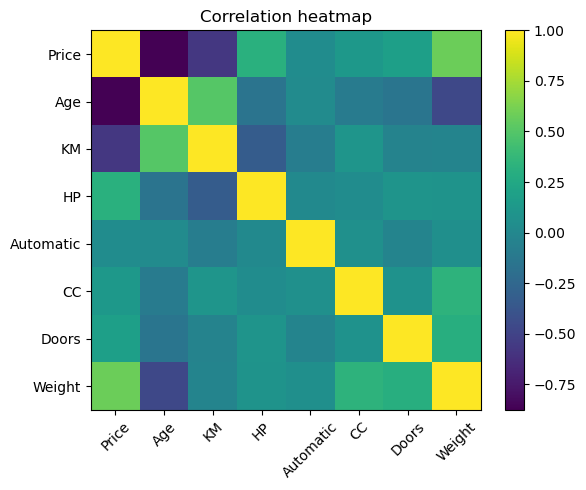

In [131]:
# Correlation matrix (numeric)
corr = data.select_dtypes(include=[np.number]).corr()
print("\nCorrelation matrix (numeric):")
display(corr.round(2))

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()

## Prepare features (X) and target (y)

In [132]:
# Separate X and y and note categorical columns for preprocessing.
X = data.drop(columns=['Price'])
y = data['Price']

# Identify categorical columns (likely FuelType)
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['FuelType']
Numeric columns: ['Age', 'KM', 'HP', 'Automatic', 'CC', 'Doors', 'Weight']


## Preprocessing pipeline

In [133]:
# OneHotEncode categorical (drop first to avoid dummy trap) and scale numeric features.
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(drop='first'), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='drop')


## Train-test split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1148, 8) Test shape: (288, 8)


## Compute VIF

In [135]:
def compute_vif_from_df(df_features):
    """Compute VIF for each feature in a pandas DataFrame (numeric)"""
    Xc = sm.add_constant(df_features)  # add constant
    vif_df = pd.DataFrame({
        'feature': Xc.columns,
        'VIF': [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    })
    return vif_df

# For VIF we need a fully numeric design matrix (one-hot + numeric)
X_trans_full = pd.DataFrame(preprocessor.fit_transform(X), 
                            columns=(preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols).tolist() 
                                     + num_cols))
print("Transformed feature columns (for VIF):", X_trans_full.columns.tolist())
vif_initial = compute_vif_from_df(X_trans_full)
display(vif_initial.sort_values('VIF', ascending=False).head(12).round(2))


Transformed feature columns (for VIF): ['FuelType_Diesel', 'FuelType_Petrol', 'Age', 'KM', 'HP', 'Automatic', 'CC', 'Doors', 'Weight']


,feature,VIF
0,const,88.72
1,FuelType_Diesel,11.25
2,FuelType_Petrol,9.63
9,Weight,3.29
5,HP,2.22
4,KM,1.99
3,Age,1.92
7,CC,1.22
8,Doors,1.17
6,Automatic,1.08


## Model 1 - sklearn Pipeline LinearRegression 

In [136]:
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

def print_metrics(y_true, y_pred, name="Model"):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

print_metrics(y_test, y_pred_lr, "Pipeline LinearRegression (Model 1)")


Pipeline LinearRegression (Model 1) -> RMSE: 1491.41, MAE: 992.30, R2: 0.8333


## Model 2 - statsmodels OLS using all features

In [137]:
# Use the transformed numeric dataframe X_trans_full and the original y aligned with it.
# Convert to numeric and add constant; statsmodels wants numpy numeric arrays.

# Align rows: preprocessor was fit on full X earlier; re-transform to ensure order matches 'data' dataset
X_trans_full = pd.DataFrame(preprocessor.transform(X), columns=X_trans_full.columns, index=X.index)

# Build OLS design matrix and ensure dtype is float
X_sm = sm.add_constant(X_trans_full).astype(float)
y_sm = y.astype(float)

# Fit OLS
model_ols_all = sm.OLS(y_sm, X_sm).fit()
print(model_ols_all.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1006.
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:30:27   Log-Likelihood:                -12374.
No. Observations:                1436   AIC:                         2.477e+04
Df Residuals:                    1426   BIC:                         2.482e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9588.9546    333.446     

## Model 3 - OLS after addressing multicollinearity

In [138]:
# Strategy: drop features with VIF > 10 (one-pass). You can iterate if needed.

vif_df = compute_vif_from_df(X_trans_full)
high_vif = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
high_vif = [f for f in high_vif if f != 'const']  # exclude constant if present
print("Features with VIF > 10 (to consider dropping):", high_vif)

# Drop features found in X_trans_full
drop_cols = [c for c in high_vif if c in X_trans_full.columns]
X_trans_reduced = X_trans_full.drop(columns=drop_cols)

# Fit OLS on reduced feature set
X_sm2 = sm.add_constant(X_trans_reduced).astype(float)
model_ols_reduced = sm.OLS(y_sm, X_sm2).fit()
print(model_ols_reduced.summary())


Features with VIF > 10 (to consider dropping): ['FuelType_Diesel']
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1130.
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:30:28   Log-Likelihood:                -12376.
No. Observations:                1436   AIC:                         2.477e+04
Df Residuals:                    1427   BIC:                         2.482e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

## Model 4 - Transform target (log) & fit OLS on reduced features

In [139]:
# Log-transform target to reduce skew & heteroscedasticity: use log1p to handle zero prices
y_log = np.log1p(y_sm)
model_ols_log = sm.OLS(y_log, X_sm2).fit()
print(model_ols_log.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     993.2
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:30:29   Log-Likelihood:                 1061.6
No. Observations:                1436   AIC:                            -2105.
Df Residuals:                    1427   BIC:                            -2058.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.2051      0.016    5

## Evaluate OLS models on test set

In [140]:
# Prepare test matrices: transform X_test and align with the same columns as training transformed
X_test_trans = pd.DataFrame(preprocessor.transform(X_test), columns=X_trans_full.columns, index=X_test.index)
X_test_reduced = X_test_trans[X_trans_reduced.columns]  # select reduced columns

# Model all-features predictions
pred_ols_all = model_ols_all.predict(sm.add_constant(X_test_trans).astype(float))
# Model reduced predictions
pred_ols_reduced = model_ols_reduced.predict(sm.add_constant(X_test_reduced).astype(float))
# Model log-target predictions (invert with expm1)
pred_ols_log = np.expm1(model_ols_log.predict(sm.add_constant(X_test_reduced).astype(float)))

print_metrics(y_test, pred_ols_all, "OLS (all features)")
print_metrics(y_test, pred_ols_reduced, "OLS (reduced features)")
print_metrics(y_test, pred_ols_log, "OLS (log-target, reduced features)")


OLS (all features) -> RMSE: 1422.36, MAE: 994.35, R2: 0.8484
OLS (reduced features) -> RMSE: 1431.20, MAE: 992.96, R2: 0.8465
OLS (log-target, reduced features) -> RMSE: 1209.80, MAE: 862.82, R2: 0.8903


## Regularized models - Lasso & Ridge

In [141]:
# We'll use pipelines with preprocessor + scaler for stability.
pipe_lasso = Pipeline([('pre', preprocessor), ('scale', StandardScaler()), ('lasso', Lasso(max_iter=5000))])
pipe_ridge = Pipeline([('pre', preprocessor), ('scale', StandardScaler()), ('ridge', Ridge(max_iter=5000))])

# Small grid for alpha to save time — expand if you want deeper tuning
params_lasso = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
params_ridge = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# GridSearch (cv=5) - may take a little time but small grids help
gs_lasso = GridSearchCV(pipe_lasso, params_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs_ridge = GridSearchCV(pipe_ridge, params_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

gs_lasso.fit(X_train, y_train)
gs_ridge.fit(X_train, y_train)

best_lasso = gs_lasso.best_estimator_
best_ridge = gs_ridge.best_estimator_

print("Best Lasso alpha:", gs_lasso.best_params_)
print("Best Ridge alpha:", gs_ridge.best_params_)

# Predictions and metrics
pred_lasso = best_lasso.predict(X_test)
pred_ridge = best_ridge.predict(X_test)

print_metrics(y_test, pred_lasso, "Lasso (best)")
print_metrics(y_test, pred_ridge, "Ridge (best)")


Best Lasso alpha: {'lasso__alpha': 1}
Best Ridge alpha: {'ridge__alpha': 10}
Lasso (best) -> RMSE: 1490.67, MAE: 992.41, R2: 0.8335
Ridge (best) -> RMSE: 1484.93, MAE: 992.18, R2: 0.8347


## Coefficients interpretation

In [142]:
# Get feature names from preprocessor for pipeline coefficients
onehot_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols).tolist() if len(cat_cols)>0 else []
feature_names = onehot_names + num_cols

# For sklearn linear model (pipe_lr) coefficients:
lr_coefs = pipe_lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': lr_coefs})
coef_df = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index)  # sort by absolute effect
print("Top coefficients (LinearRegression):")
display(coef_df.head(12))

# For Lasso and Ridge (best estimators), extract coefficients similarly
lasso_coefs = best_lasso.named_steps['lasso'].coef_
ridge_coefs = best_ridge.named_steps['ridge'].coef_

coef_df_lasso = pd.DataFrame({'feature': feature_names, 'coef_lasso': lasso_coefs})
coef_df_ridge = pd.DataFrame({'feature': feature_names, 'coef_ridge': ridge_coefs})

print("Lasso coefficients (top absolute):")
display(coef_df_lasso.reindex(coef_df_lasso['coef_lasso'].abs().sort_values(ascending=False).index).head(12))

print("Ridge coefficients (top absolute):")
display(coef_df_ridge.reindex(coef_df_ridge['coef_ridge'].abs().sort_values(ascending=False).index).head(12))


Top coefficients (LinearRegression):


,feature,coef
2,Age,-2267.156303
1,FuelType_Petrol,1453.694461
8,Weight,1326.190352
3,KM,-600.179991
4,HP,234.138332
7,Doors,-80.500836
5,Automatic,21.512689
6,CC,-14.098311
0,FuelType_Diesel,4.202110


Lasso coefficients (top absolute):


,feature,coef_lasso
2,Age,-2266.737764
8,Weight,1322.978307
3,KM,-600.747506
1,FuelType_Petrol,481.840344
4,HP,234.231847
7,Doors,-78.754506
5,Automatic,20.784030
6,CC,-12.762983
0,FuelType_Diesel,-0.000000


Ridge coefficients (top absolute):


,feature,coef_ridge
2,Age,-2244.450522
8,Weight,1303.760165
3,KM,-616.741937
1,FuelType_Petrol,444.815769
4,HP,244.940561
7,Doors,-72.471416
5,Automatic,23.009283
6,CC,-12.545610
0,FuelType_Diesel,-8.986133


## Simple model comparison table

In [143]:
comparison = pd.DataFrame({
    'model': ['Pipeline LR', 'OLS (all)', 'OLS (reduced)', 'OLS (log->inv)', 'Lasso', 'Ridge'],
    'RMSE': [
        mean_squared_error(y_test, y_pred_lr, squared=False),
        mean_squared_error(y_test, pred_ols_all, squared=False),
        mean_squared_error(y_test, pred_ols_reduced, squared=False),
        mean_squared_error(y_test, pred_ols_log, squared=False),
        mean_squared_error(y_test, pred_lasso, squared=False),
        mean_squared_error(y_test, pred_ridge, squared=False)
    ],
    'R2': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, pred_ols_all),
        r2_score(y_test, pred_ols_reduced),
        r2_score(y_test, pred_ols_log),
        r2_score(y_test, pred_lasso),
        r2_score(y_test, pred_ridge)
    ]
}).round(4)

display(comparison.sort_values('RMSE'))


,model,RMSE,R2
3,OLS (log->inv),1209.8046,0.8903
1,OLS (all),1422.3556,0.8484
2,OLS (reduced),1431.1969,0.8465
5,Ridge,1484.9265,0.8347
4,Lasso,1490.6679,0.8335
0,Pipeline LR,1491.4108,0.8333


## Interview Questions

**1. What is Normalization & Standardization and how is it helpful?**

Normalization (Min–Max): rescales data to a fixed range, typically [0,1]. Formula: (x - min) / (max - min).

Useful when you need bounded inputs (e.g., neural networks using sigmoid) or when features have different units and you want them on the same scale.

Standardization (Z-score): rescales data to have mean 0 and standard deviation 1. Formula: (x - mean) / std.

Useful for algorithms that assume features are centered (e.g., linear regression regularization, PCA, gradient-based methods). Standardization preserves outliers but rescales them relative to the spread.

Why helpful: Many ML algorithms are sensitive to feature scale; standardization/normalization improves numerical stability and often speeds up convergence and improves regularized models’ behavior.

**2. What techniques can be used to address multicollinearity in MLR?**

Detect using correlation matrix and Variance Inflation Factor (VIF).

Remove or combine correlated predictors.

Use principal components (PCR) or Partial Least Squares (PLS).

Use regularized regression (Ridge reduces coefficient variance; Lasso can perform variable selection).

Center variables (subtract mean) or construct orthogonal variables/transformations.

Collect more data if possible (to reduce variance of estimates).